# Building a Robot Judge - Problem Set 1 - Solution Raphael Husistein

In [154]:
import pickle
import spacy
import os
import math
import re
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from collections import Counter

## General functions that are used across solutions (possibly for later reuse)
This functions will be used across the different problem sets for easy data processing.

In [195]:
def get_all_case_filenames():
    """Return a list of all filenames in the cases directory"""
    cases = []
    for root, dirs, files in os.walk("./cases/", topdown=False):
        for name in files:
            cases.append(os.path.join(root, name))
    return cases

def normalize_text(doc):
    """
    Return cleaned list of tokens
    Removes: punctuation, numbers, spaces, stop words, and drops non alphabetic chars 
    """
    tokens = [token for token in doc if not token.is_punct | token.is_space | token.like_num | token.is_stop and token.is_alpha]
    return tokens

def get_cleaned_string_from_file(filename):
    """Return the content of a file as a string with the first line removed and newlines striped"""
    with open(filename, "r", encoding="utf-8") as file:
        # skip the first line with the name of the judge
        content = ""
        for line in islice(file, 1, None):
            content += line.strip()
    return content

def get_spacy_doc(nlp, string):
    """Load a string into a spacy document"""
    return nlp(string)

def get_sentences(nlp, doc):
    """Return all sentences of a spacy doc"""
    return [sent.string.strip() for sent in doc.sents]

def get_sentences_for_w2vec(nlp, doc):
    """Return all sentences as a nested list e. g. [["This", "is", "sent", "1"], ["This", "is", "sent", "2"]]"""
    return [[token.text for token in sent if not token.is_punct | token.is_space | token.like_num and token.is_alpha] for sent in doc.sents]

def get_words(nlp, doc):
    """Return all tokens except punctuation from a spacy document (=words)"""
    return [token.text for token in doc if not token.is_punct and not token.is_currency and not token.like_num]

def get_year_from_filename(filename):
    """Return the year extracted from the filename"""
    return re.search("\d{4}", filename).group(0)

def get_case_name_from_filename(filename):
    """Return the case name extracted from the filename"""
    return re.search("(?<=\d{4}\_).*(?=\.)", filename).group(0)


def custom_pipeline(nlp):
    """Return custom spacy pipeline"""
    return (nlp.parser) 


def color_func(word=None, font_size=None, position=None, orientation=None, random_state=None, font_path=None):
    """Return a random color that can be used in word clouds"""
    color = random.randint(0, 360)
    return "hsl({}, {}%, {}%)".format(color, random.randint(65, 75), random.randint(35, 45))


def average_cosine_similarity(model, word, word_list):
    """Return the average cosine similarity between all the words in word_list and word"""
    similarities = [model.wv.n_similarity([word], [w]) for w in word_list]
    return sum(similarities)/len(similarities)
    

def average_cosine_similarity_difference(model, word, word_list_1, word_list_2):
    """Return the difference of the average cosine similarity of word_list_1 to word and word_list_2 to word"""
    return average_cosine_similarity(model, word, word_list_1) - average_cosine_similarity(model, word, word_list_2)

def weat_test(model, attribute_words_1, attribute_words_2, target_words_1, target_words_2):
    """Return the difference of the sum of the average cosine similarity between all target words from set1 and all attribute words"""
    target_1 = [average_cosine_similarity_difference(republican_model, w, attribute_words_1, attribute_words_2) for w in target_words_1]
    target_2 = [average_cosine_similarity_difference(republican_model, w, attribute_words_1, attribute_words_2) for w in target_words_2]
    return sum(target_1)-sum(target_2)

def p_value_test(model, target_words_1, target_words_2, attribute_words_1, attribute_words_2):
    """Return the one sided p-value of the permutation test """
    test_stat = weat_test(model, attribute_words_1, attribute_words_2, target_words_1, target_words_2)
    observed_over = []
    all_targets = target_words_1 + target_words_2
    for c in itertools.combinations(all_targets, len(target_words_1)):
        not_c = itertools.filterfalse(lambda x: x in c, all_targets)
        stat = weat_test(model, attribute_words_1, attribute_words_2, c, not_c)
        observed_over.append(stat > test_stat)
    return(np.mean(observed_over))

def effect_size(model, attribute_words_1, attribute_words_2, target_words_1, target_words_2):
    targ_sims1 = np.array([average_cosine_similarity_difference(model, w, attribute_words_1, attribute_words_2) for w in target_words_1])
    targ_sims2 = np.array([average_cosine_similarity_difference(democrat_model, w, attribute_words_1, attribute_words_2) for w in target_words_2])
    numerator = np.mean(targ_sims1) - np.mean(targ_sims2)
    denominator = np.std(np.concatenate([targ_sims1, targ_sims2]))
    return numerator/denominator

def create_features(x): 
    X = np.zeros((len(unique_words), 1))
    for value in x:
        if value in frequencies.keys():
            frequencies[value] += 1
    return X


def create_feature_set_from_df(df):
    feature_values = df["features"].values
    feature_values = np.reshape(np.vstack(feature_values), (len(df), len(unique_words)))
    return feature_values

def ols_double_predict(target, data_1, data_2):
    return (LinearRegression().fit(target, data_1), LinearRegression().fit(target, data_2))

def ols_predict(target, data):
    return LinearRegression().fit(target, data)

def get_error(values, model, features):
    error = values - model.predict(features)
    error = np.reshape(error, (half_length, 1))
    return error

## Solution for Task 1

**Task**: Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to demonstrate the difference between the models.

**Solution:**
First I load all the spacy docs from a pickle file (to save some time).
Then I train a word2vec model with a window size of 2 and one with a window size of 16. I expect that with a window size of 2 the words that are close together are most likely simple substitutes as not much context is used in the embedding.
On the other hand with a large window size of 16 I expect that words which appear in the same context are close but they do are not necessarily substitutes as we capture alot of context with a window size of 16.

You can't see the effect I suspected from the pictures below. The words are closer together at small window size. However not even the close ones are really synonyms.

In [5]:
NUMBER_OF_CASES = 2500
nlp = spacy.load("en", create_pipeline=custom_pipeline)
cases_dataframe = pd.DataFrame()
filenames = get_all_case_filenames()

#spacy_docs = [(filename, get_spacy_doc(nlp, get_cleaned_string_from_file(filename))) for filename in filenames[:NUMBER_OF_CASES]]
file = open("spacy_docs.dat", "rb")
spacy_docs = pickle.load(file)
file.close()

In [6]:
sentences = list(itertools.chain.from_iterable([get_sentences_for_w2vec(nlp, doc[1]) for doc in spacy_docs]))
random.shuffle(sentences)
small_window_model = Word2Vec( 
    sentences,
    size=200, # 200-dimensional word vectors
    window=2, # window size of 2 
    min_count=1, # ignore words with frequency less than 
    workers=8, # use 8 cores for full speed ;D,
    sample=1e-5 # use frequent words less often in training the word2vec model
)
small_window_word_vectors = small_window_model.wv
del small_window_model

large_window_model = Word2Vec( 
    sentences,
    size=200, # 200-dimensional word vectors
    window=16, # window size of 2 
    min_count=1, # ignore words with frequency less than 
    workers=8, # use 8 cores for full speed ;D,
    sample=1e-5 # use frequent words less often in training the word2vec model
)
large_window_word_vectors = large_window_model.wv
del large_window_model

C:\Users\test\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:316: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


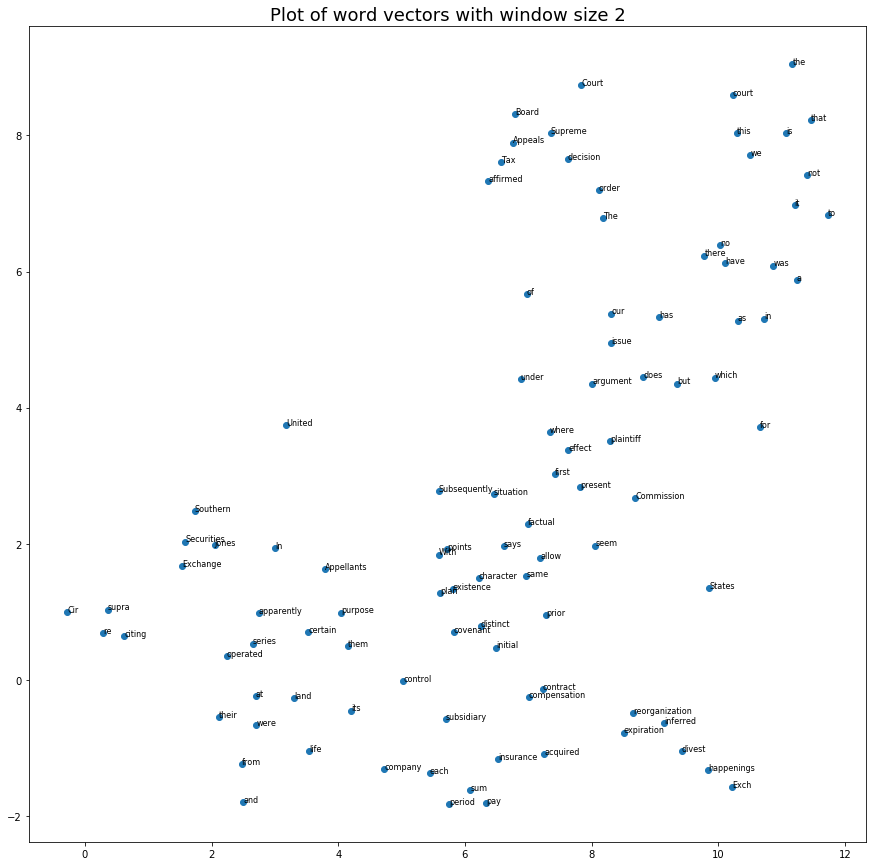

In [8]:
small_window_vocab = list(small_window_word_vectors.vocab)
small_X = small_window_word_vectors[small_window_vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(small_X[:100,:])

df = pd.DataFrame(X_tsne, index=small_window_vocab[:100], columns=["x", "y"])
fig = plt.figure(figsize=(15, 15))
plt.title("Plot of word vectors with window size 2", fontsize=18)
plt.scatter(df["x"], df["y"])
for word, pos in itertools.islice(df.iterrows(), 100):
    plt.annotate(word, pos, fontsize=8)
plt.show()

C:\Users\test\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:316: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


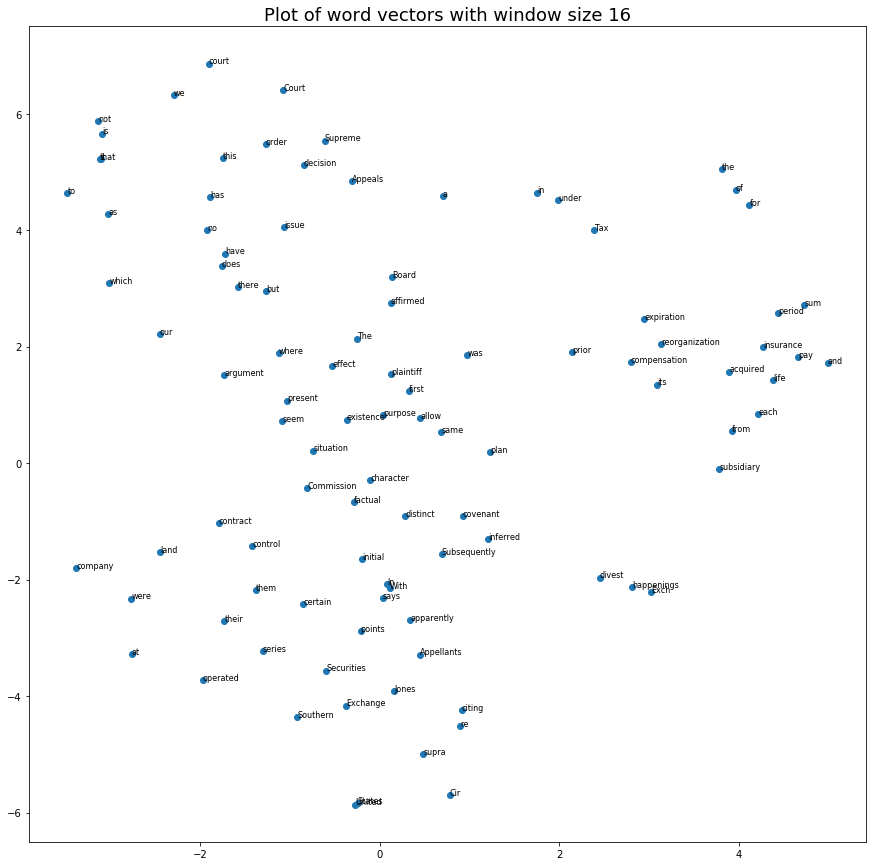

In [9]:
large_window_vocab = list(large_window_word_vectors.vocab)
large_X = large_window_word_vectors[large_window_vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(large_X[:100,:])

df = pd.DataFrame(X_tsne, index=large_window_vocab[:100], columns=["x", "y"])
fig = plt.figure(figsize=(15, 15))
plt.title("Plot of word vectors with window size 16", fontsize=18)
plt.scatter(df["x"], df["y"])
for word, pos in itertools.islice(df.iterrows(), 100):
    plt.annotate(word, pos, fontsize=8)
plt.show()

## Solution for Task 2

**Task:** Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the adjectives most associated with a social group or concept of your choice (following, for example, the method in Caliskan et al 2017 or Kozlowski et al 2018), and analyze differences by judge party.

**Solution:** First I load the metadata in to a pandas dataframe. Then I build two different lists each of them only contains the sentences used by a judge from the corresponding party. I then train two different Word2Vec models with this lists of sentences. I get the top 5000 nearest words from the democrat word2vec (and the republican word2vec model) and filter out the 25 most common adjectives. Then I create wordclouds for both the republican and the democrat adjectives. Bigger words are nearer to the word "rich".
The word cloud of the democrats has a slightly negative tendency against the word rich (manipulative, crooked, raw) whereas the republican wordcloud shows more neutral adjectives.

I then used the WEAT metric (as described in [Caliskan et al](https://science.sciencemag.org/content/356/6334/183/tab-pdf)) to measure gender bias towards different crimes. The table below shows the results for the democrat judge.

| Target Words                  | Attribute Words          | d     | P    |
|-------------------------------|--------------------------|-------|------|
| Murder, Rape, Accident, Theft | Man, Male, Woman, Female | 0.925 | 0.17 |

The table below shows the results for republican judges.

| Target Words                  | Attribute Words          | d     | P    |
|-------------------------------|--------------------------|-------|------|
| Murder, Rape, Accident, Theft | Man, Male, Woman, Female | 1.47  | 0.17 |

With both categories we have a relatively large d-value (effect-size). But the p-value shows us that most likely the 0-hypothesis ( = there is no no difference between the two sets of target
words in terms of their relative similarity to the two sets of attribute words) ist most likely true.

In [118]:
republican_sentences = []
democrat_sentences = []
metadata = pd.read_csv("case_metadata.csv")
metadata["log_cites"].fillna(0, inplace=True)
metadata = metadata[pd.notnull(metadata["x_republican"])]
for doc in spacy_docs:
    case_id = get_case_name_from_filename(doc[0])
    if metadata.loc[metadata["caseid"] == case_id]["x_republican"].all() == 0:
        democrat_sentences.extend(get_sentences_for_w2vec(nlp, doc[1]))
    else:
        republican_sentences.extend(get_sentences_for_w2vec(nlp, doc[1]))
random.shuffle(republican_sentences)
random.shuffle(democrat_sentences)

In [11]:
republican_model = Word2Vec( 
    republican_sentences,
    size=300, # 300-dimensional word vectors
    window=5, # window size of 5 
    min_count=1, # ignore words with frequency less than 
    workers=8, # use 8 cores for full speed ;D,
    sample=1e-5, # use frequent words less often in training the word2vec model,
    sg=1, # use skip gram,
    alpha=0.025,
    min_alpha=0.0001,
    iter=20 # numer of training epochs
)

democrat_model = Word2Vec( 
    democrat_sentences,
    size=300, # 300-dimensional word vectors
    window=5, # window size of 5
    min_count=1, # ignore words with frequency less than 
    workers=8, # use 8 cores for full speed ;D,
    sample=1e-5, # use frequent words less often in training the word2vec model,
    sg=1, # use skip gram,
    alpha=0.025,
    min_alpha=0.0001,
    iter=20 # numer of training epochs
)

In [315]:
controversial_topic = "rich"
democrat_adjectives = {}
democrat_nearest_words_spacy = nlp(" ".join([word[0] for word in democrat_model.wv.most_similar(controversial_topic, topn=5000)]))
for word in  democrat_nearest_words_spacy:
    if word.pos_ == "ADJ":
        democrat_adjectives[word.text] = democrat_model.wv.n_similarity([controversial_topic], [word.text])
    if len(democrat_adjectives) == 25:
        break
        
republican_adjectives = {}
republican_nearest_words_spacy = nlp(" ".join([word[0] for word in republican_model.wv.most_similar(controversial_topic, topn=5000)]))
for word in  republican_nearest_words_spacy:
    if word.pos_ == "ADJ":
        republican_adjectives[word.text] = republican_model.wv.n_similarity([controversial_topic], [word.text])
    if len(republican_adjectives) == 25:
        break

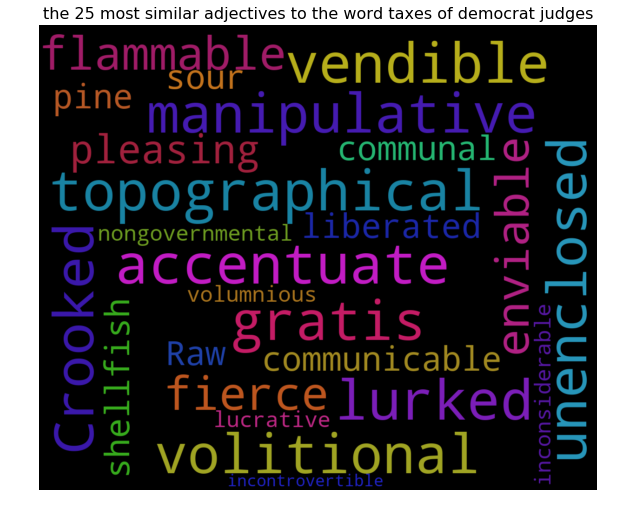

In [295]:
wordcloud = WordCloud(
    background_color="black", 
    ranks_only=False, 
    max_font_size=120,
    color_func=color_func,
    height=1000,width=1200).generate_from_frequencies(democrat_adjectives)
plt.figure(figsize=(10, 10))
plt.title("the 25 most similar adjectives to the word taxes of democrat judges", fontsize=16)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [296]:
wordcloud = WordCloud(
    background_color="black", 
    ranks_only=False, 
    max_font_size=120,
    color_func=color_func,
    height=1000,width=1200).generate_from_frequencies(republican_adjectives)
plt.figure(figsize=(10, 10))
plt.title("the 25 most similar adjectives to the word taxes of republican judges", fontsize=16)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [428]:
target_words_1 = ["murder", "rape"]
target_words_2 = ["accident", "theft"]
attribute_words_1 = ["female", "woman"]
attribute_words_2 = ["man", "male"]

test_stat = weat_test(democrat_model, attribute_words_1, attribute_words_2, target_words_1, target_words_2)
p_value = p_value_test(democrat_model, target_words_1, target_words_2, attribute_words_1, attribute_words_2)
effect = effect_size(democrat_model, attribute_words_1, attribute_words_2, target_words_1, target_words_2)
print(effect)
print(p_value)

0.925382917403039
0.16666666666666666


In [429]:
target_words_1 = ["murder", "rape"]
target_words_2 = ["accident", "theft"]
attribute_words_1 = ["female", "woman"]
attribute_words_2 = ["man", "male"]

test_stat = weat_test(republican_model, attribute_words_1, attribute_words_2, target_words_1, target_words_2)
p_value = p_value_test(republican_model, target_words_1, target_words_2, attribute_words_1, attribute_words_2)
effect = effect_size(republican_model, attribute_words_1, attribute_words_2, target_words_1, target_words_2)
print(effect)
print(p_value)

1.470722085059679
0.16666666666666666


## Solution for Task 3

**Task:** Implement one of the causal inference methods from Lecture 12

**Solution:**
I want to use the double ML method (by Chernozhukov et al (2017)) to analyse the effect of the political party on wether a case is revered or not.
My results suggest that there is a positive effect of republican to reversal.
e.g. a republican is more likely to reverse a verdict.

In [191]:
unique_words = set()
metadata["text"] = ""
for doc in spacy_docs:
    case_id = get_case_name_from_filename(doc[0])
    metadata.loc[metadata.caseid == filename, "text"] = " ".join([token.text.lower() for token in normalize_text(doc[1])])
    unique_words.update(token.text.lower() for token in normalize_text(doc[1]))
frequencies = {word: i for i, word in enumerate(unique_words)}
# now we have saved the frequencies of the words as feature vectors
metadata["features"] = metadata.text.apply(lambda x: create_features(x))
metadata.head()

caseid  case_reversed  judge_id    year  x_republican  log_cites text  \
0  X3JGGO              0    1653.0  1925.0           1.0   1.098612        
1  X3OH3J              0    1034.0  1924.0           0.0   1.609438        
2  X3U0KO              0    2303.0  1925.0           0.0   1.791759        
3  X53HAD              0    1764.0  1924.0           0.0   0.000000        
4  X9VC5V              0     493.0  1925.0           1.0   0.000000        

                                            features  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
1  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
2  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
3  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
4  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [196]:
half_length = math.floor(len(metadata) / 2)
reversed_values = metadata["case_reversed"].values
feature_values = create_feature_set_from_df(metadata)
republican_values = metadata["x_republican"].values
feature_values_part_1 = feature_values[:half_length, :]
reversed_values_part_1 = reversed_values[:half_length]
republican_values_part_1 = republican_values[:half_length]
feature_values_part_2 = feature_values[half_length:, :]
reversed_values_part_2 = reversed_values[half_length:]
republican_values_part_2 = republican_values[half_length:]
predict_reversed_1, predict_republican_1 = ols_double_predict(feature_values_part_1, reversed_values_part_1, republican_values_part_1)
predict_reversed_2, predict_republican_2 = ols_double_predict(feature_values_part_2, reversed_values_part_2, republican_values_part_2)
predict_reversed_error_1 = get_error(reversed_values_part_1, predict_reversed_2, feature_values_part_1)
predict_republican_error_1 = republican_values_part_1 - predict_republican_2.predict(feature_values_part_1)
predict_reversed_error_2 = get_error(reversed_values_part_2, predict_reversed_1, feature_values_part_2)
predict_republican_error_2 = republican_values_part_2 - predict_republican_1.predict(feature_values_part_2)
regress_1 = ols_predict(predict_reversed_error_1, predict_republican_error_1)
regress_2 = ols_predict(predict_reversed_error_2, predict_republican_error_2)
print((regress_1.coef_ + regress_2.coef_) / 2)

[0.18294239]
